In [89]:
# from hgraph import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

In [90]:
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdMolDescriptors



In [91]:

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import py3Dmol
from IPython.display import display


#### 0. universal helper functions


In [92]:


def draw_with_spheres(mol):
    v = py3Dmol.view(width=300,height=300)
    mol_block = Chem.MolToMolBlock(mol)
    v.addModel(mol_block, "mol")
    v.zoomTo()
    v.setStyle({'sphere':{'radius':0.3},'stick':{'radius':0.2}})
    v.show()


# I. Defining viz functions

In [93]:
def MolFromSMILES():
    smiles_list = [
        "CSc1ccccc1C(=O)Nc1ccc2c(c1)OCCO2",
        # "CC(C)NC(=N)c1ccc(OCCCCCOc2ccc(C(=N)NC(C)C)cc2C(=O)O)c(C(=O)O)c1",
        # "O=C(Cn1cn[nH]c1=O)N1CC2(CCCC2)c2ccccc21"
    ]
    mols = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            Chem.Kekulize(mol, clearAromaticFlags=True)
        mols.append(mol)
    return mols

# mols = MolFromSMILES()

# print("Visualizing the input molecule from SMILES:")
# for mol in mols:
#     draw_with_spheres(mol)
# draw_with_spheres(mols[0])

In [94]:
def build_mol_graph(mol):
    graph = nx.DiGraph(Chem.rdmolops.GetAdjacencyMatrix(mol))
    for atom in mol.GetAtoms():
        graph.nodes[atom.GetIdx()]['label'] = (atom.GetSymbol(), atom.GetFormalCharge())

    BOND_LIST = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        btype = BOND_LIST.index(bond.GetBondType())
        graph[a1][a2]['label'] = btype
        graph[a2][a1]['label'] = btype

    return graph

def find_clusters(mol):
    n_atoms = mol.GetNumAtoms()
    if n_atoms == 1:
        return [(0,)], [[0]]

    clusters = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        if not bond.IsInRing():
            clusters.append((a1, a2))

    ssr = [tuple(x) for x in Chem.GetSymmSSSR(mol)]
    clusters.extend(ssr)

    if clusters and 0 not in clusters[0]:
        for i, cls in enumerate(clusters):
            if 0 in cls:
                clusters = [clusters[i]] + clusters[:i] + clusters[i+1:]
                break

    atom_cls = [[] for _ in range(n_atoms)]
    for i in range(len(clusters)):
        for atom in clusters[i]:
            atom_cls[atom].append(i)

    return clusters, atom_cls

def tree_decomp(clusters, atom_cls):
    graph = nx.Graph()
    for i in range(len(clusters)):
        graph.add_node(i)

    for atom, nei_cls in enumerate(atom_cls):
        if len(nei_cls) <= 1:
            continue
        bonds = [c for c in nei_cls if len(clusters[c]) == 2]
        rings = [c for c in nei_cls if len(clusters[c]) > 4]

        if len(nei_cls) > 2 and len(bonds) >= 2:
            clusters.append([atom])
            c2 = len(clusters) - 1
            graph.add_node(c2)
            for c1 in nei_cls:
                graph.add_edge(c1, c2, weight=100, type='condition1')

        elif len(rings) > 2:
            clusters.append([atom])
            c2 = len(clusters) - 1
            graph.add_node(c2)
            for c1 in nei_cls:
                graph.add_edge(c1, c2, weight=100, type='condition2')

        else:
            for i, c1 in enumerate(nei_cls):
                for c2 in nei_cls[i + 1:]:
                    inter = set(clusters[c1]) & set(clusters[c2])
                    graph.add_edge(c1, c2, weight=len(inter), type='condition3')

    n, m = len(clusters), len(graph.edges)
    assert n - m <=1 # must be connected

    # This part is being done in visualize function
    # if n - m == 1:
    #     return graph, clusters
    # else:
    #     print(f"Applying maximum_spanning_tree because n - m = {n - m} < 1")
    #     return nx.maximum_spanning_tree(graph), clusters

    return graph, clusters

### I.a. Defining `find_clusters` FUNCTION: 1. Non-ring bonds (red) 2. Rings (green)

In [95]:

print("VISUALIZING `find_clusters` FUNCTION: 1. Non-ring bonds (red) 2. Rings (green)")

def visualize_clusters(mol):
    clusters, atom_cls = find_clusters(mol)
    
    # Non-ring bonds
    non_ring_bonds = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds() if not bond.IsInRing()]
    print("non-ring bonds: ", non_ring_bonds)
    
    # Rings
    ssr = Chem.GetSymmSSSR(mol)
    rings_print = [list(ring) for ring in ssr]
    print("rings: ", rings_print)
    
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), label=f"{atom.GetSymbol()}{atom.GetIdx()}")
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    pos = nx.spring_layout(G)
    
    # Draw non-ring bonds
    nx.draw(G, pos, ax=ax1, node_color='lightblue', node_size=700, with_labels=True, labels={node: G.nodes[node]['label'] for node in G.nodes()})
    nx.draw_networkx_edges(G, pos, ax=ax1, edgelist=non_ring_bonds, edge_color='r', width=2)
    ax1.set_title('Non-ring bonds (red)')
    
    # Draw rings
    nx.draw(G, pos, ax=ax2, node_color='lightblue', node_size=700, with_labels=True, labels={node: G.nodes[node]['label'] for node in G.nodes()})
    for ring in ssr:
        ring = list(ring) 
        ring_edges = list(zip(ring, ring[1:] + ring[:1]))
        nx.draw_networkx_edges(G, pos, ax=ax2, edgelist=ring_edges, edge_color='g', width=2)
    ax2.set_title('Rings (green)')
    
    # Add cluster IDs
    for i, cluster in enumerate(clusters):
        cluster_center = np.mean([pos[node] for node in cluster], axis=0)
        ax1.text(cluster_center[0], cluster_center[1], f'c:{i}', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        ax2.text(cluster_center[0], cluster_center[1], f'c:{i}', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    print("Clusters:")
    for i, cluster in enumerate(clusters):
        print(f"c:{i} -- {cluster}")
    return clusters, atom_cls

# clusters_allmols = []
# atom_cls_all = []
# for i, mol in enumerate(mols):
#     print(f"Clusters for molecule {i+1}:")
#     clusters, atom_cls = visualize_clusters(mol)
#     clusters_allmols.append(clusters)
#     atom_cls_all.append(atom_cls)

VISUALIZING `find_clusters` FUNCTION: 1. Non-ring bonds (red) 2. Rings (green)


### I.b. Visualizing `tree_decomp` i.e. how a graph is constructed from individual nodes (i.e. clusters)

In [96]:
def visualize_tree_decomp(mol, clusters, atom_cls):
    # mg = MolGraph(mol)
    
    def draw_graph(G, title):
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(G)
        
        nx.draw_networkx_nodes(G, pos, node_size=[len(clusters[n])*100 for n in G.nodes()])
        
        # edges with different colors based on their type
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for (u, v, d) in G.edges(data=True) if d['type'] == 'condition1'], edge_color='r', width=2)
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for (u, v, d) in G.edges(data=True) if d['type'] == 'condition2'], edge_color='g', width=2)
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for (u, v, d) in G.edges(data=True) if d['type'] == 'condition3'], edge_color='b', width=2)
        
        labels = {i: f"{i}: {clusters[i]}" for i in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, font_size=8)
        
        plt.title(title)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    graph, updated_clusters = tree_decomp(clusters, atom_cls)
    draw_graph(graph, "Graph after all edges are added")

    draw_graph(graph, "Graph after all edges are added again")

    n, m = len(graph.nodes), len(graph.edges)
    print(f"Nodes: {n}, Edges: {m}")
    assert n - m <= 1 #must be connected
    print("n - m == 1: ", n - m == 1)
    print("n - m <= 1: ", n - m <= 1)
    if n - m == 1:
        print("Graph is already a tree, no further visualization needed")
        mst = graph
    else:
        mst = nx.maximum_spanning_tree(graph)
        draw_graph(mst, "Graph after applying maximum_spanning_tree")
    # graph if n - m == 1 else nx.maximum_spanning_tree(graph)
    return mst, updated_clusters

# # Visualize tree decomposition for each molecule
# print(" VISUALIZING `tree_decomp` FUNCTION: 1. Red edges: condition1 2. Green edges: condition2 3. Blue edges: condition3")
# for i, mol in enumerate(mols):
#     print(f"Tree decomposition for molecule {i+1}:")
#     visualize_tree_decomp(mol)

# II. MAIN VISUALIZATION

In [97]:
mols = MolFromSMILES()

print("Visualizing the input molecule from SMILES:")
for mol in mols:
    draw_with_spheres(mol)

Visualizing the input molecule from SMILES:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [98]:
# mol_graphs = build_mol_graph(mols[0])
mol_graphs = []
for i, mol in enumerate(mols):
	mol_graph = build_mol_graph(mol)
	mol_graphs.append(mol_graph)

### a. Visualizing `find_clusters` function: 1. Non-ring bonds (red) 2. Rings (green)

VISUALIZING `find_clusters` FUNCTION: 1. Non-ring bonds (red) 2. Rings (green)
Clusters for molecule 1:
non-ring bonds:  [(0, 1), (1, 2), (7, 8), (8, 9), (8, 10), (10, 11)]
rings:  [[2, 7, 6, 5, 4, 3], [12, 13, 14, 15, 16, 11], [17, 18, 19, 20, 14, 15]]


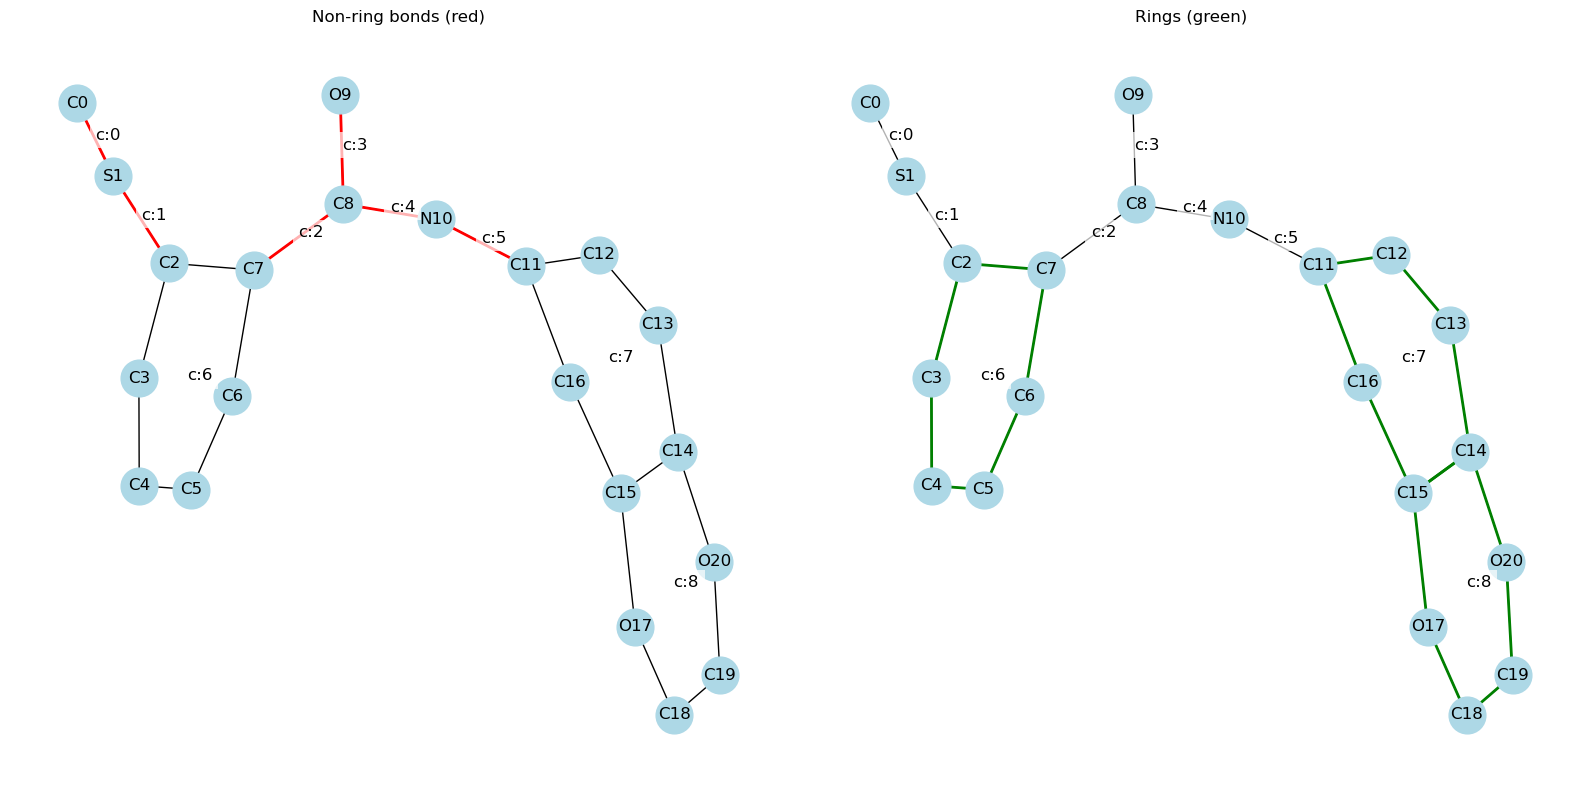

Clusters:
c:0 -- (0, 1)
c:1 -- (1, 2)
c:2 -- (7, 8)
c:3 -- (8, 9)
c:4 -- (8, 10)
c:5 -- (10, 11)
c:6 -- (2, 7, 6, 5, 4, 3)
c:7 -- (12, 13, 14, 15, 16, 11)
c:8 -- (17, 18, 19, 20, 14, 15)


In [99]:
print("VISUALIZING `find_clusters` FUNCTION: 1. Non-ring bonds (red) 2. Rings (green)")
clusters_allmols = []
atom_cls_allmols = []
for i, mol in enumerate(mols):
    print(f"Clusters for molecule {i+1}:")
    clusters, atom_cls = visualize_clusters(mol)
    clusters_allmols.append(clusters)
    atom_cls_allmols.append(atom_cls)

### b. VISUALIZING `tree_decomp` FUNCTION: 1. red edges: condition1 2. green edges: condition2 3. blue edges: condition3 

 **`tree_decomp` : how graph is constructed from individual nodes (aka clusters)** -

- Doubts(DONE): 
    - graph vs tree where happening exactly here, mst here, clarify later. Shouldn't a graph be created before mst is applied as per your understanding ? why are you getting tree directly?
        - Answered through your discussion with biswajit/kushang, basically, a loop can be formed only in 1 or 2 condition, where a new cluster is created for that node to ensure it is a tree. In 3rd condition, no loop is formed because <=2 clusters (atom is shared by <= 2 clusters).

For every atom that is shared between at least 2 neighboring clusters:

1. If the atom is shared by more than 2 clusters, and at least 2 of these clusters are bonds (clusters of size 2):
    - A new cluster is created containing just this atom.
    - Edges are added between this new cluster and all the clusters that contain this atom.
    - These edges are given a high weight (100).
2. If the atom is shared by more than 2 rings (clusters of size > 4):
    - Again, a new cluster is created containing just this atom.
    - Edges are added between this new cluster and all the clusters that contain this atom.
    - These edges are also given a high weight (100).
3. If neither of the above conditions are met:
    - Edges are added between all pairs of clusters that contain this atom.
    - The weight of each edge is set to the number of atoms shared between the two clusters.

VISUALIZING `tree_decomp` FUNCTION: 1. Red edges: condition1 2. Green edges: condition2 3. Blue edges: condition3
Tree decomposition for molecule 1:


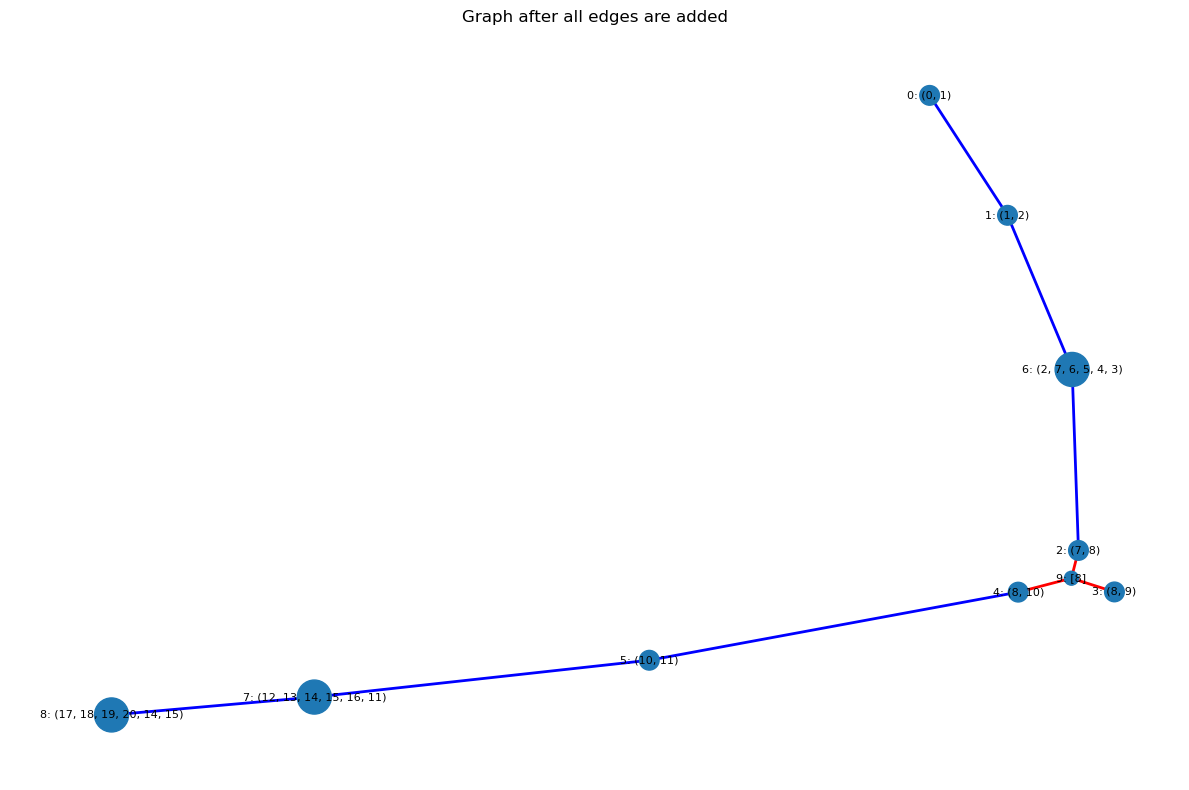

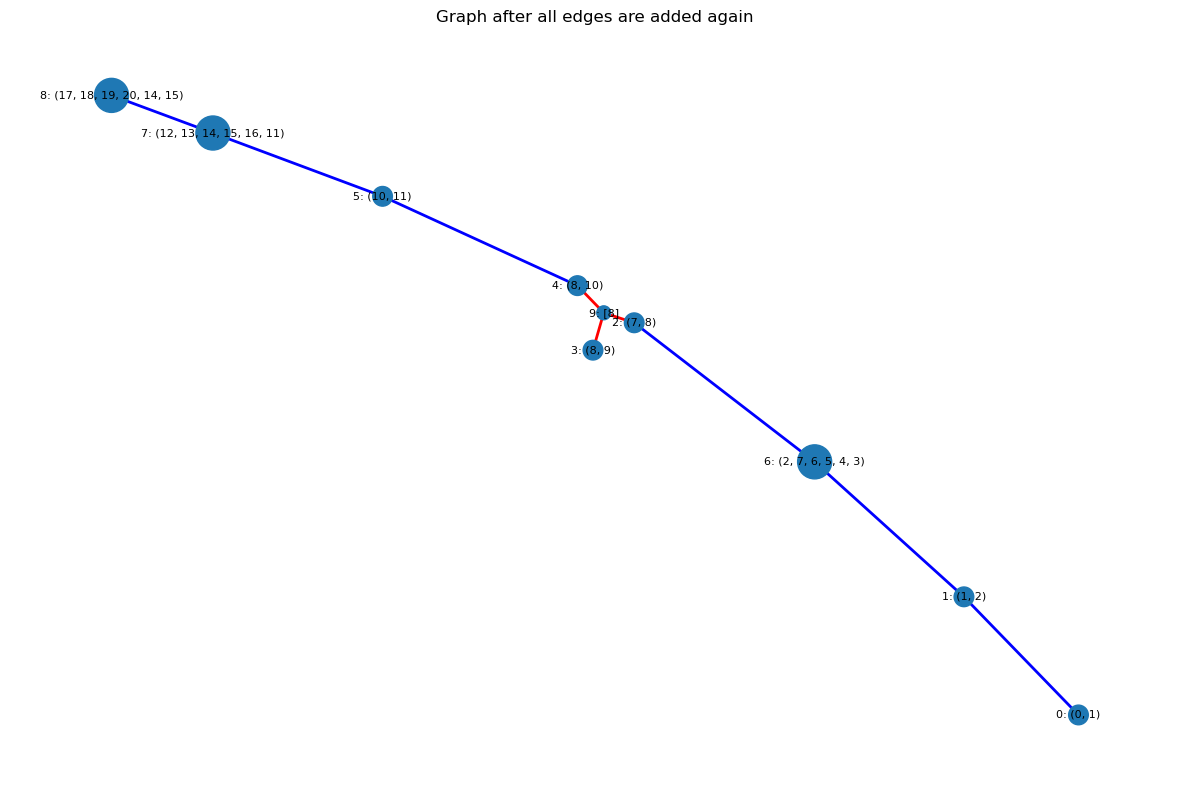

Nodes: 10, Edges: 9
n - m == 1:  True
n - m <= 1:  True
Graph is already a tree, no further visualization needed


In [100]:
print("VISUALIZING `tree_decomp` FUNCTION: 1. Red edges: condition1 2. Green edges: condition2 3. Blue edges: condition3")
trees_allmols = []
updated_clusters_all_mols = []
for i, mol in enumerate(mols):
    print(f"Tree decomposition for molecule {i+1}:")
    tree, updated_clusters =  visualize_tree_decomp(mol, clusters_allmols[i], atom_cls_allmols[i])
    trees_allmols.append(tree)
    # clusters_allmols[i] = updated_clusters # wrong
    updated_clusters_all_mols.append(updated_clusters)

# IMPORTANT: Replacing the clusters with updated clusters
clusters_allmols = updated_clusters_all_mols

In [101]:
print(clusters_allmols)

[[(0, 1), (1, 2), (7, 8), (8, 9), (8, 10), (10, 11), (2, 7, 6, 5, 4, 3), (12, 13, 14, 15, 16, 11), (17, 18, 19, 20, 14, 15), [8]]]


-  Notice [8] above: new cluster getting added during tree decomposition

In [102]:
print()

### c. VISUALIZING `label_tree`: It is complex than before so we will visualize it in parts as follows:



1. Depth-First Search (DFS) Traversal
	- Visualize the order in which nodes are visited
	- Show parent-child relationships
	- Illustrate the assignment of labels to edges

2. Anchor and Inter-atom labeling
	- Show how anchors are identified
	- Visualize the process of creating inter-labels

3. Atom mapping
	- Display how atoms are mapped in the original molecule

4. Cluster and inter-label assignment
	- Visualize the assignment of SMILES and inter-labels to each cluster

5. Assembly candidates
	- Show how assembly candidates are determined for each cluster


#### c.1 core functions

In [103]:
from hgraph.chemutils import get_clique_mol, is_anchor, get_anchor_smiles, set_atommap
from hgraph.chemutils import get_smiles

idxfunc = lambda a : a.GetAtomMapNum() - 1

In [104]:
def get_inter_label(mol, atoms, inter_atoms):
    new_mol = get_clique_mol(mol, atoms)
    
    if new_mol.GetNumBonds() == 0:
        inter_atom = list(inter_atoms)[0]
        for a in new_mol.GetAtoms():
            a.SetAtomMapNum(0)
        return new_mol, [(inter_atom, Chem.MolToSmiles(new_mol))]
    
    inter_label = []
    for a in new_mol.GetAtoms():
        idx = idxfunc(a)
        if idx in inter_atoms and is_anchor(a, inter_atoms):
            inter_label.append((idx, get_anchor_smiles(new_mol, idx)))

    for a in new_mol.GetAtoms():
        a.SetAtomMapNum( 1 if idxfunc(a) in inter_atoms else 0 )
    
    return new_mol, inter_label


def get_assm_cands(mol, atoms, inter_label, cluster, inter_size):
    atoms = list(set(atoms))
    mol = get_clique_mol(mol, atoms)
    atom_map = [idxfunc(atom) for atom in mol.GetAtoms()]
    mol = set_atommap(mol)
    rank = Chem.CanonicalRankAtoms(mol, breakTies=False)
    rank = { x:y for x,y in zip(atom_map, rank) }

    pos, icls = zip(*inter_label)
    if inter_size == 1:
        cands = [pos[0]] + [ x for x in cluster if rank[x] != rank[pos[0]] ] 
    
    elif icls[0] == icls[1]: #symmetric case
        shift = cluster[inter_size - 1:] + cluster[:inter_size - 1]
        cands = zip(cluster, shift)
        cands = [pos] + [ (x,y) for x,y in cands if (rank[min(x,y)],rank[max(x,y)]) != (rank[min(pos)], rank[max(pos)]) ]
    else: 
        shift = cluster[inter_size - 1:] + cluster[:inter_size - 1]
        cands = zip(cluster + shift, shift + cluster)
        cands = [pos] + [ (x,y) for x,y in cands if (rank[x],rank[y]) != (rank[pos[0]], rank[pos[1]]) ]

    return cands



In [105]:

def label_tree(mol, tree, clusters, mol_graph):
    # for viz
    cmol_list = []
    inter_label_list = []

    def dfs(order, pa, prev_sib, x, fa):
        pa[x] = fa
        sorted_child = sorted([y for y in tree[x] if y != fa])
        for idx, y in enumerate(sorted_child):
            tree[x][y]['label'] = 0
            tree[y][x]['label'] = idx + 1  # position encoding
            prev_sib[y] = sorted_child[:idx]
            prev_sib[y] += [x, fa] if fa >= 0 else [x]
            order.append((x, y, 1))
            dfs(order, pa, prev_sib, y, x)
            order.append((y, x, 0))

    order, pa = [], {}
    tree = nx.DiGraph(tree)
    prev_sib = [[] for _ in range(len(clusters))]
    dfs(order, pa, prev_sib, 0, -1)
    order.append((0, None, 0))  # last backtrack at root

    # TODO: Should you recreate mol object? See original code which does it from smiles

    # mol = get_mol(smiles)
    for a in mol.GetAtoms():
        a.SetAtomMapNum(a.GetIdx() + 1)

    for i, cls in enumerate(clusters):
        inter_atoms = set(cls) & set(clusters[pa[i]]) if pa[i] >= 0 else set([0])
        cmol, inter_label = get_inter_label(mol, cls, inter_atoms)

        # for viz
        # duplicate cmol
        cmol_viz = Chem.Mol(cmol)
        cmol_list.append(cmol_viz)
        inter_label_list.append(inter_label)

        tree.nodes[i]['ismiles'] = ismiles = get_smiles(cmol)
        tree.nodes[i]['inter_label'] = inter_label
        tree.nodes[i]['smiles'] = smiles = get_smiles(set_atommap(cmol))
        tree.nodes[i]['label'] = (smiles, ismiles) if len(cls) > 1 else (smiles, smiles)
        tree.nodes[i]['cluster'] = cls
        tree.nodes[i]['assm_cands'] = []

        if pa[i] >= 0 and len(clusters[pa[i]]) > 2:  # uncertainty occurs in assembly
            hist = [a for c in prev_sib[i] for a in clusters[c]]
            pa_cls = clusters[pa[i]]
            tree.nodes[i]['assm_cands'] = get_assm_cands(mol, hist, inter_label, pa_cls, len(inter_atoms))

            child_order = tree[i][pa[i]]['label']
            diff = set(cls) - set(pa_cls)
            for fa_atom in inter_atoms:
                for ch_atom in mol_graph[fa_atom]:
                    if ch_atom in diff:
                        label = mol_graph[ch_atom][fa_atom]['label']
                        if type(label) is int: #in case one bond is assigned multiple times
                            mol_graph[ch_atom][fa_atom]['label'] = (label, child_order)

    return order, tree, mol_graph, cmol_list, inter_label_list

#### c.2 visualization functions

- TODO-Later
	- implicit H representation: In `get_inter_label()`, `mol.GetTotalH = 0` but `new_mol.GetTotalH >0`. Why is implicit/explicit hydrogen behaving differently?
	- anchors: confusion in `is_anchor()`
	- 

In [106]:

def visualize_dfs_traversal(mol, labeled_tree, order):
    print("Visualizing DFS Traversal:")
    G = nx.DiGraph(labeled_tree)
    
    if len(G.nodes) == 0:
        print("Error: The tree is empty. There's nothing to visualize.")
        return
    
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(12, 8))
    
    edge_labels = {}
    node_colors = ['lightblue' for _ in G.nodes()]
    edge_colors = ['black' for _ in G.edges()]
    
    print("DFS Traversal steps:")
    for i, (u, v, direction) in enumerate(order):
        if v is None:
            print(f"Step {i+1}: Backtrack to root")
            continue
        
        print(f"Step {i+1}: {'Forward' if direction == 1 else 'Backward'} edge ({u}, {v})")
        
        # Update colors
        node_colors = ['lightblue' for _ in G.nodes()]
        edge_colors = ['lightgray' for _ in G.edges()]
        
        node_colors[u] = 'yellow'  # Current node
        if v in G.nodes():
            node_colors[v] = 'green'  # Next node
        
        if direction == 1:
            edge_labels[(u, v)] = f"{labeled_tree[u][v]['label']}"
            edge_colors[list(G.edges()).index((u, v))] = 'red'  # Current edge
        else:
            edge_colors[list(G.edges()).index((u, v))] = 'blue'  # Backtracking edge
        
        # Draw the graph
        plt.clf()
        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=700, edge_color=edge_colors, width=2)
        
        # Add cluster information to node labels
        node_labels = {node: f"{node}\n{labeled_tree.nodes[node]['cluster']}" for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
        
        # Add edge labels
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        
        # Add direction arrows
        edge_arrows = [(u, v)] if direction == 1 else [(v, u)]
        nx.draw_networkx_edges(G, pos, edgelist=edge_arrows, arrows=True, arrowsize=20, edge_color='r', width=2)
        
        plt.title(f"Step {i+1}: {'Forward' if direction == 1 else 'Backward'} edge ({u}, {v})")
        plt.pause(0.5)
    
    print("\nFinal DFS Traversal order:", order)
    plt.show()

    # Display additional information
    print("\nAdditional Tree Information:")
    for node in labeled_tree.nodes():
        print(f"Node {node}:")
        print(f"  Cluster: {labeled_tree.nodes[node]['cluster']}")
        print(f"  SMILES: {labeled_tree.nodes[node]['smiles']}")
        print(f"  Inter-label: {labeled_tree.nodes[node]['inter_label']}")
        if 'assm_cands' in labeled_tree.nodes[node] and labeled_tree.nodes[node]['assm_cands']:
            print(f"  Assembly Candidates: {labeled_tree.nodes[node]['assm_cands']}")
        print()

In [107]:
def visualize_inter_label(cmol_list, inter_label_list):
    print("Visualizing Inter-label Information:")
    
    for i, (cmol, inter_label) in enumerate(zip(cmol_list, inter_label_list)):
        print(f"\nCluster {i}:")
        smiles_cmol_before = Chem.MolToSmiles(cmol)
        print(f"\nBefore AddH: SMILES: {smiles_cmol_before}")
        
        # Add hydrogens
        cmol = Chem.AddHs(cmol)
        
        # Generate 2D coordinates for the molecule
        AllChem.Compute2DCoords(cmol)
        
        # Prepare atom colors and labels
        highlight_atoms = []
        highlight_colors = {}
        atom_labels = {}
        for atom in cmol.GetAtoms():
            idx = atom.GetIdx()
            highlight_atoms.append(idx)
            if atom.GetAtomMapNum() == 1:  # Anchor atom
                highlight_colors[idx] = (1, 0, 0)  # Red for anchor atoms
                atom_labels[idx] = f"{atom.GetSymbol()}{idx}"
                print(f"Atom {idx} is an anchor atom: symbol={atom.GetSymbol()}, formal charge={atom.GetFormalCharge()}")
            else:
                highlight_colors[idx] = (0.8, 0.8, 0.8)  # Light gray for non-anchor atoms
                atom_labels[idx] = f"{atom.GetSymbol()}{idx}"
                print(f"Atom {idx} is not an anchor atom: symbol={atom.GetSymbol()}, formal charge={atom.GetFormalCharge()}")
        
        # Draw the molecule
        img = Draw.MolToImage(cmol, size=(500, 500), highlightAtoms=highlight_atoms, 
                              highlightAtomColors=highlight_colors,
                              highlightBonds=[],
                              atmLabelPadding=0.03,
                              atoms=atom_labels)
        
        display(img)
        # cmol to smiles
        smiles_cmol = Chem.MolToSmiles(cmol)
        print(f"CMOL: SMILES: {smiles_cmol}")
        print(f"CMOL: Chemical Formula: {Chem.rdMolDescriptors.CalcMolFormula(cmol)}")

        
        print("Inter-label information:")
        for idx, smiles in inter_label:
            print(f"  Atom {idx}: {smiles}")
            tempmol = Chem.MolFromSmiles(smiles)
            chemical_formula = rdMolDescriptors.CalcMolFormula(tempmol)
            print(f"  Chemical Formula: {chemical_formula}")
        
        print(f"Molecular Weight: {Descriptors.ExactMolWt(cmol):.2f}")
        print(f"Number of Atoms: {cmol.GetNumAtoms()}")
        print(f"Number of Bonds: {cmol.GetNumBonds()}")
        
        print("\n" + "-"*50)  # Separator between clusters

In [108]:


# def visualize_assm_cands(mol, labeled_tree, clusters):
#     print("Visualizing Assembly Candidates:")
    
#     for node in labeled_tree.nodes():
#         if 'assm_cands' in labeled_tree.nodes[node] and labeled_tree.nodes[node]['assm_cands']:
#             parent = list(labeled_tree.predecessors(node))[0]
            
#             print(f"\nAssembly candidates for node {node} (parent: {parent}):")
#             print(f"Candidates: {labeled_tree.nodes[node]['assm_cands']}")
            
#             # Create parent and child molecules
#             parent_mol = Chem.MolFromSmiles(labeled_tree.nodes[parent]['smiles'])
#             child_mol = Chem.MolFromSmiles(labeled_tree.nodes[node]['smiles'])
            
#             # Highlight atoms involved in assembly
#             parent_atoms = set(clusters[parent])
#             child_atoms = set(clusters[node])
#             interface_atoms = parent_atoms.intersection(child_atoms)
            
#             # Set up the plot
#             fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
            
#             # Visualize parent molecule
#             img = Draw.MolToImage(parent_mol, highlightAtoms=list(interface_atoms))
#             ax1.imshow(img)
#             ax1.set_title("Parent Cluster")
#             ax1.axis('off')
            
#             # Visualize child molecule
#             img = Draw.MolToImage(child_mol, highlightAtoms=list(interface_atoms))
#             ax2.imshow(img)
#             ax2.set_title("Child Cluster")
#             ax2.axis('off')
            
#             # Create a schematic diagram
#             ax3.set_xlim(0, 1)
#             ax3.set_ylim(0, 1)
#             ax3.add_patch(plt.Circle((0.3, 0.5), 0.3, fill=False))
#             ax3.add_patch(plt.Circle((0.7, 0.5), 0.3, fill=False))
#             ax3.text(0.3, 0.5, "Parent", ha='center', va='center')
#             ax3.text(0.7, 0.5, "Child", ha='center', va='center')
#             for cand in labeled_tree.nodes[node]['assm_cands']:
#                 if isinstance(cand, tuple):
#                     ax3.plot([0.3, 0.7], [0.5, 0.5], 'r-')
#                 else:
#                     ax3.plot([0.3, 0.7], [0.5, 0.5], 'g-')
#             ax3.set_title("Assembly Schematic")
#             ax3.axis('off')
            
#             plt.tight_layout()
#             plt.show()
            
#             print(f"Parent SMILES: {labeled_tree.nodes[parent]['smiles']}")
#             print(f"Child SMILES: {labeled_tree.nodes[node]['smiles']}")
#             print(f"Interface atoms: {interface_atoms}")
#             print("-" * 50)


def simple_visualize_assm_cands(labeled_tree):
    print("Simple Visualization of :")
    print("  a. FINAL vocab output: i.e. `label`(ismiles) and `inter_label`")
    print("      a.1 Also notice difference between them")
    print("  b. Assembly Candidates:")
    print("--------------------------------------------")

    for node in sorted(labeled_tree.nodes()):
        assm_cands = labeled_tree.nodes[node].get('assm_cands', [])
        print(f"labeled_tree.nodes[{node}]")

        inter_label = labeled_tree.nodes[node].get('inter_label', [])
        print(f"  ['inter_label']")
        print(f"   > {inter_label}")

        label = labeled_tree.nodes[node].get('label', [])
        print(f"  ['label']")
        print(f"   > {label}")

        print(f"  ['assm_cands']")
        if assm_cands:
            print(f"   > {assm_cands}")
        else:
            print(f"   > []  # Empty list")

        print()  # Add a blank line for readability

    print("--------------------------------------------")

#### c.3 MAIN visualization

In [109]:
def visualize_label_tree(mol, tree, clusters, mol_graph):
    order, labeled_tree, mol_graph, cmol_list, inter_label_list = label_tree(mol, tree, clusters, mol_graph)
    print(order)
    
    # visualize_dfs_traversal(mol, labeled_tree, order)
    visualize_inter_label(cmol_list, inter_label_list)
    simple_visualize_assm_cands(labeled_tree)

    # old
    # visualize_atom_mapping(mol)
    # visualize_cluster_assignments(mol, labeled_tree, clusters)
    # visualize_assembly_candidates(mol, labeled_tree, clusters)

VISUALIZING `label_tree` FUNCTION:

Labeling tree for molecule 1:
[(0, 1, 1), (1, 6, 1), (6, 2, 1), (2, 9, 1), (9, 3, 1), (3, 9, 0), (9, 4, 1), (4, 5, 1), (5, 7, 1), (7, 8, 1), (8, 7, 0), (7, 5, 0), (5, 4, 0), (4, 9, 0), (9, 2, 0), (2, 6, 0), (6, 1, 0), (1, 0, 0), (0, None, 0)]
Visualizing Inter-label Information:

Cluster 0:

Before AddH: SMILES: S[CH3:1]
Atom 0 is an anchor atom: symbol=C, formal charge=0
Atom 1 is not an anchor atom: symbol=S, formal charge=0
Atom 2 is not an anchor atom: symbol=H, formal charge=0
Atom 3 is not an anchor atom: symbol=H, formal charge=0
Atom 4 is not an anchor atom: symbol=H, formal charge=0
Atom 5 is not an anchor atom: symbol=H, formal charge=0


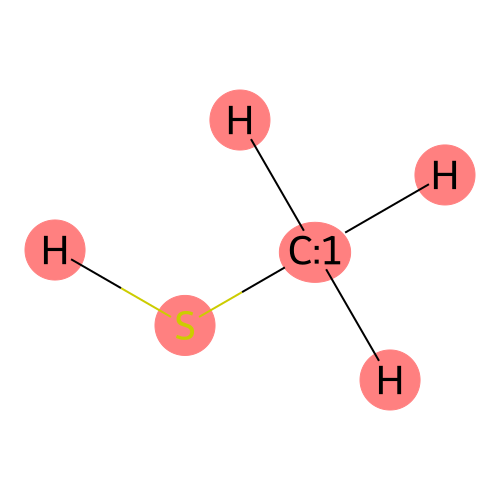

CMOL: SMILES: [H]S[C:1]([H])([H])[H]
CMOL: Chemical Formula: CH4S
Inter-label information:
  Atom 0: S[CH3:1]
  Chemical Formula: CH4S
Molecular Weight: 48.00
Number of Atoms: 6
Number of Bonds: 5

--------------------------------------------------

Cluster 1:

Before AddH: SMILES: C[SH:1]
Atom 0 is an anchor atom: symbol=S, formal charge=0
Atom 1 is not an anchor atom: symbol=C, formal charge=0
Atom 2 is not an anchor atom: symbol=H, formal charge=0
Atom 3 is not an anchor atom: symbol=H, formal charge=0
Atom 4 is not an anchor atom: symbol=H, formal charge=0
Atom 5 is not an anchor atom: symbol=H, formal charge=0


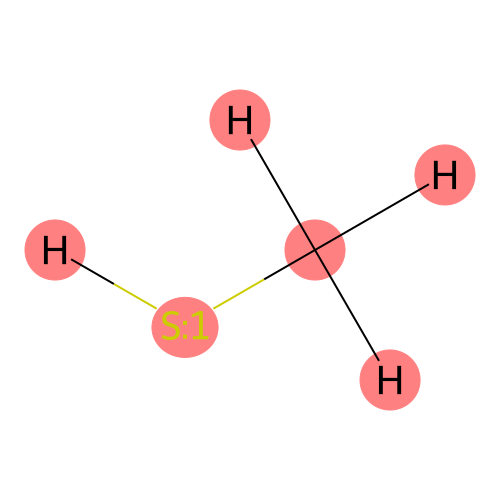

CMOL: SMILES: [H]C([H])([H])[S:1][H]
CMOL: Chemical Formula: CH4S
Inter-label information:
  Atom 1: C[SH:1]
  Chemical Formula: CH4S
Molecular Weight: 48.00
Number of Atoms: 6
Number of Bonds: 5

--------------------------------------------------

Cluster 2:

Before AddH: SMILES: C[CH3:1]
Atom 0 is an anchor atom: symbol=C, formal charge=0
Atom 1 is not an anchor atom: symbol=C, formal charge=0
Atom 2 is not an anchor atom: symbol=H, formal charge=0
Atom 3 is not an anchor atom: symbol=H, formal charge=0
Atom 4 is not an anchor atom: symbol=H, formal charge=0
Atom 5 is not an anchor atom: symbol=H, formal charge=0
Atom 6 is not an anchor atom: symbol=H, formal charge=0
Atom 7 is not an anchor atom: symbol=H, formal charge=0


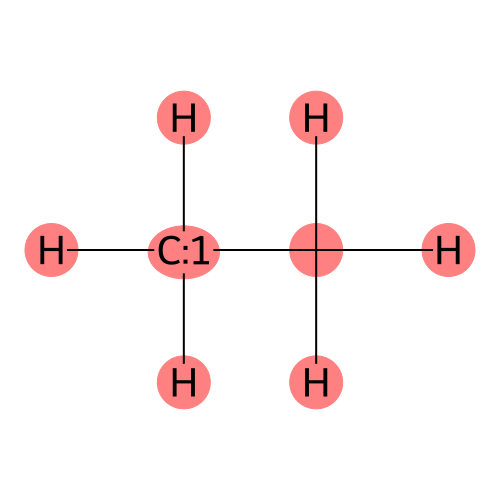

CMOL: SMILES: [H]C([H])([H])[C:1]([H])([H])[H]
CMOL: Chemical Formula: C2H6
Inter-label information:
  Atom 7: C[CH3:1]
  Chemical Formula: C2H6
Molecular Weight: 30.05
Number of Atoms: 8
Number of Bonds: 7

--------------------------------------------------

Cluster 3:

Before AddH: SMILES: O=[CH2:1]
Atom 0 is an anchor atom: symbol=C, formal charge=0
Atom 1 is not an anchor atom: symbol=O, formal charge=0
Atom 2 is not an anchor atom: symbol=H, formal charge=0
Atom 3 is not an anchor atom: symbol=H, formal charge=0


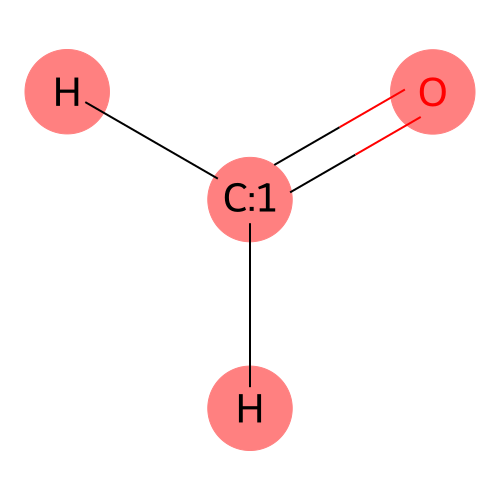

CMOL: SMILES: [H][C:1]([H])=O
CMOL: Chemical Formula: CH2O
Inter-label information:
  Atom 8: O=[CH2:1]
  Chemical Formula: CH2O
Molecular Weight: 30.01
Number of Atoms: 4
Number of Bonds: 3

--------------------------------------------------

Cluster 4:

Before AddH: SMILES: N[CH3:1]
Atom 0 is an anchor atom: symbol=C, formal charge=0
Atom 1 is not an anchor atom: symbol=N, formal charge=0
Atom 2 is not an anchor atom: symbol=H, formal charge=0
Atom 3 is not an anchor atom: symbol=H, formal charge=0
Atom 4 is not an anchor atom: symbol=H, formal charge=0
Atom 5 is not an anchor atom: symbol=H, formal charge=0
Atom 6 is not an anchor atom: symbol=H, formal charge=0


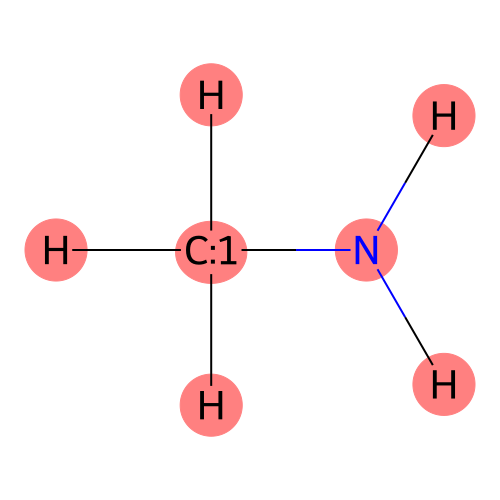

CMOL: SMILES: [H]N([H])[C:1]([H])([H])[H]
CMOL: Chemical Formula: CH5N
Inter-label information:
  Atom 8: N[CH3:1]
  Chemical Formula: CH5N
Molecular Weight: 31.04
Number of Atoms: 7
Number of Bonds: 6

--------------------------------------------------

Cluster 5:

Before AddH: SMILES: C[NH2:1]
Atom 0 is an anchor atom: symbol=N, formal charge=0
Atom 1 is not an anchor atom: symbol=C, formal charge=0
Atom 2 is not an anchor atom: symbol=H, formal charge=0
Atom 3 is not an anchor atom: symbol=H, formal charge=0
Atom 4 is not an anchor atom: symbol=H, formal charge=0
Atom 5 is not an anchor atom: symbol=H, formal charge=0
Atom 6 is not an anchor atom: symbol=H, formal charge=0


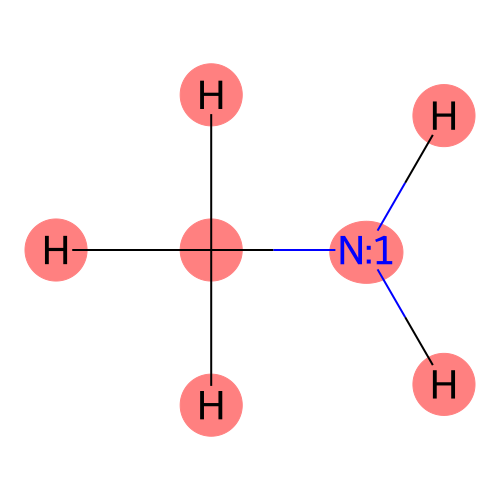

CMOL: SMILES: [H]C([H])([H])[N:1]([H])[H]
CMOL: Chemical Formula: CH5N
Inter-label information:
  Atom 10: C[NH2:1]
  Chemical Formula: CH5N
Molecular Weight: 31.04
Number of Atoms: 7
Number of Bonds: 6

--------------------------------------------------

Cluster 6:

Before AddH: SMILES: C1=CC=[CH:1]C=C1
Atom 0 is an anchor atom: symbol=C, formal charge=0
Atom 1 is not an anchor atom: symbol=C, formal charge=0
Atom 2 is not an anchor atom: symbol=C, formal charge=0
Atom 3 is not an anchor atom: symbol=C, formal charge=0
Atom 4 is not an anchor atom: symbol=C, formal charge=0
Atom 5 is not an anchor atom: symbol=C, formal charge=0
Atom 6 is not an anchor atom: symbol=H, formal charge=0
Atom 7 is not an anchor atom: symbol=H, formal charge=0
Atom 8 is not an anchor atom: symbol=H, formal charge=0
Atom 9 is not an anchor atom: symbol=H, formal charge=0
Atom 10 is not an anchor atom: symbol=H, formal charge=0
Atom 11 is not an anchor atom: symbol=H, formal charge=0


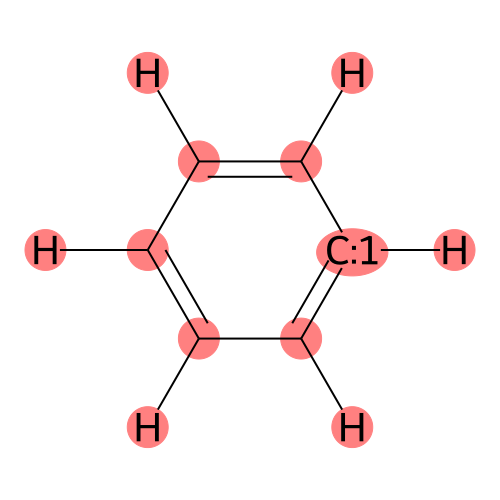

CMOL: SMILES: [H]C1=C([H])C([H])=[C:1]([H])C([H])=C1[H]
CMOL: Chemical Formula: C6H6
Inter-label information:
  Atom 2: C1=CC=[CH:1]C=C1
  Chemical Formula: C6H6
Molecular Weight: 78.05
Number of Atoms: 12
Number of Bonds: 12

--------------------------------------------------

Cluster 7:

Before AddH: SMILES: C1=CC=[CH:1]C=C1
Atom 0 is an anchor atom: symbol=C, formal charge=0
Atom 1 is not an anchor atom: symbol=C, formal charge=0
Atom 2 is not an anchor atom: symbol=C, formal charge=0
Atom 3 is not an anchor atom: symbol=C, formal charge=0
Atom 4 is not an anchor atom: symbol=C, formal charge=0
Atom 5 is not an anchor atom: symbol=C, formal charge=0
Atom 6 is not an anchor atom: symbol=H, formal charge=0
Atom 7 is not an anchor atom: symbol=H, formal charge=0
Atom 8 is not an anchor atom: symbol=H, formal charge=0
Atom 9 is not an anchor atom: symbol=H, formal charge=0
Atom 10 is not an anchor atom: symbol=H, formal charge=0
Atom 11 is not an anchor atom: symbol=H, formal charge=0


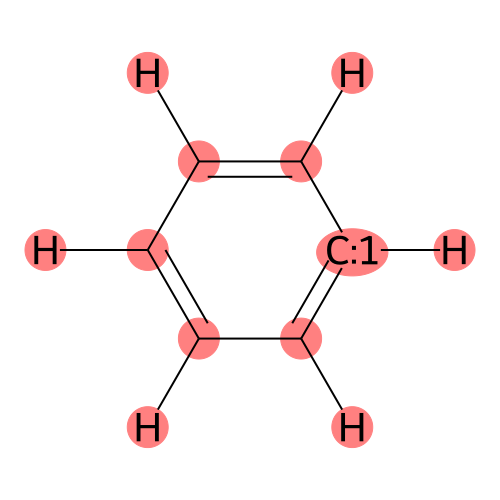

CMOL: SMILES: [H]C1=C([H])C([H])=[C:1]([H])C([H])=C1[H]
CMOL: Chemical Formula: C6H6
Inter-label information:
  Atom 11: C1=CC=[CH:1]C=C1
  Chemical Formula: C6H6
Molecular Weight: 78.05
Number of Atoms: 12
Number of Bonds: 12

--------------------------------------------------

Cluster 8:

Before AddH: SMILES: C1CO[CH2:1][CH2:1]O1
Atom 0 is an anchor atom: symbol=C, formal charge=0
Atom 1 is an anchor atom: symbol=C, formal charge=0
Atom 2 is not an anchor atom: symbol=O, formal charge=0
Atom 3 is not an anchor atom: symbol=C, formal charge=0
Atom 4 is not an anchor atom: symbol=C, formal charge=0
Atom 5 is not an anchor atom: symbol=O, formal charge=0
Atom 6 is not an anchor atom: symbol=H, formal charge=0
Atom 7 is not an anchor atom: symbol=H, formal charge=0
Atom 8 is not an anchor atom: symbol=H, formal charge=0
Atom 9 is not an anchor atom: symbol=H, formal charge=0
Atom 10 is not an anchor atom: symbol=H, formal charge=0
Atom 11 is not an anchor atom: symbol=H, formal charge=0


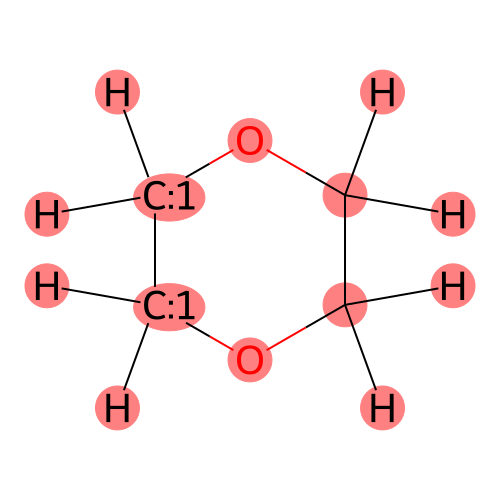

CMOL: SMILES: [H]C1([H])O[C:1]([H])([H])[C:1]([H])([H])OC1([H])[H]
CMOL: Chemical Formula: C4H8O2
Inter-label information:
  Atom 14: C1CO[CH2:1]CO1
  Chemical Formula: C4H8O2
  Atom 15: C1CO[CH2:1]CO1
  Chemical Formula: C4H8O2
Molecular Weight: 88.05
Number of Atoms: 14
Number of Bonds: 14

--------------------------------------------------

Cluster 9:

Before AddH: SMILES: C
Atom 0 is not an anchor atom: symbol=C, formal charge=0
Atom 1 is not an anchor atom: symbol=H, formal charge=0
Atom 2 is not an anchor atom: symbol=H, formal charge=0
Atom 3 is not an anchor atom: symbol=H, formal charge=0
Atom 4 is not an anchor atom: symbol=H, formal charge=0


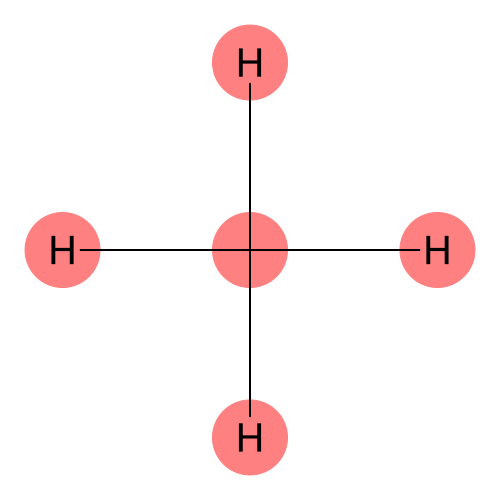

CMOL: SMILES: [H]C([H])([H])[H]
CMOL: Chemical Formula: CH4
Inter-label information:
  Atom 8: C
  Chemical Formula: CH4
Molecular Weight: 16.03
Number of Atoms: 5
Number of Bonds: 4

--------------------------------------------------
Simple Visualization of :
  a. FINAL vocab output: i.e. `label`(ismiles) and `inter_label`
      a.1 Also notice difference between them
  b. Assembly Candidates:
--------------------------------------------
labeled_tree.nodes[0]
  ['inter_label']
   > [(0, 'S[CH3:1]')]
  ['label']
   > ('CS', 'S[CH3:1]')
  ['assm_cands']
   > []  # Empty list

labeled_tree.nodes[1]
  ['inter_label']
   > [(1, 'C[SH:1]')]
  ['label']
   > ('CS', 'C[SH:1]')
  ['assm_cands']
   > []  # Empty list

labeled_tree.nodes[2]
  ['inter_label']
   > [(7, 'C[CH3:1]')]
  ['label']
   > ('CC', 'C[CH3:1]')
  ['assm_cands']
   > [7, 2, 6, 5, 4, 3]

labeled_tree.nodes[3]
  ['inter_label']
   > [(8, 'O=[CH2:1]')]
  ['label']
   > ('C=O', 'O=[CH2:1]')
  ['assm_cands']
   > []  # Empty list

In [110]:

print("VISUALIZING `label_tree` FUNCTION:")
labeled_trees_allmols = []
for i, mol in enumerate(mols):
    print(f"\nLabeling tree for molecule {i+1}:")
    visualize_label_tree(mol, trees_allmols[i], clusters_allmols[i], mol_graphs[i])
 

#### TODO: Questions for full conceptual understanding:

Moved to [personal notion page](https://www.notion.so/saishubodh/Understanding-HierVAE-hgraph2graph-code-vocabulary-construction-model-training-later-bf39b6cffc31428da29cab2f859e23a1?pvs=4)
